# Introduction to Dataset

This dataset contains an airline passenger satisfaction survey. It was created by observing the passengers from past flights of an airline company. It consists of factors that are supposed to affect the passengers' satisfaction during the journey. Most of them are personal information (eg. gender, age), flight information (eg. gate location, arrival delay) and ratings appointed by the passengers for flights services (eg. food, wi-fi).

Our purpose is to use the labeled training data to train our models and accurately predict, given a test dataset, which passengers were left satisfied.

In [ ]:
# Install ray
! pip install tune-sklearn ray[tune]

     |████████████████████████████████| 40 kB 916 kB/s eta 0:00:01


# Data Overview

In [ ]:
import numpy as np
import csv
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import sys
np.set_printoptions(threshold=sys.maxsize)

We first import our data from the kaggle library.

In [ ]:
# Import our data set from directory
directory = "/kaggle/input/airline-passenger-satisfaction/"
feature_tables = ['train.csv', 'test.csv']

df_train = directory + feature_tables[0]
df_test = directory + feature_tables[1]

df = pd.read_csv(df_train, index_col=0)
df2 = pd.read_csv(df_test, index_col=0)

We gain a sample view of our dataset.

In [ ]:
df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


Obviously the id does not contain useful information and we can discard it.

In [ ]:
df.drop('id', inplace=True, axis=1)
df2.drop('id', inplace=True, axis=1)

# Show one of them
df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


As part of our preprocessing we want to check if our dataset has missing values.

In [ ]:
df.isnull().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

In [ ]:
df2.isnull().sum()

Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0
dtype: int64

No missing values belong to categorical features. Therefore we will handle them after handling the categorical features, so as not to switch our data back and forth from pandas to numpy arrays.

Reading the dataset informaton we can deduce that we have some categorical features that are not compatible with the sklearn classifiers, so we use get_dummies to make them numerical. We also drop one of the columns that would be created since we have few distinct values (maximum 3) and the resulting columns would be highly correlated.

In [ ]:
categorical = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']

maxDistinct = 0
for column in categorical:
    distinctRows1 = df[column].nunique()
    distinctRows2 = df2[column].nunique()
    if distinctRows1 > maxDistinct:
        maxDistinct = distinctRows1
    if distinctRows2 > maxDistinct:
        maxDistinct = distinctRows2

print('The maximum number of distinct values of a categorical feature is', maxDistinct)

The maximum number of distinct values of a categorical feature is 3


In [ ]:
# Categorical to numerical in train set
for column in categorical:
    numerical = pd.get_dummies(df[column], drop_first=True)
    df = pd.concat([df, numerical], axis=1)
    df.drop(column, inplace=True, axis=1)

df.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Male,disloyal Customer,Personal Travel,Eco,Eco Plus,satisfied
0,13,460,3,4,3,1,5,3,5,5,...,5,5,25,18.0,1,0,1,0,1,0
1,25,235,3,2,3,3,1,3,1,1,...,4,1,1,6.0,1,1,0,0,0,0
2,26,1142,2,2,2,2,5,5,5,5,...,4,5,0,0.0,0,0,0,0,0,1
3,25,562,2,5,5,5,2,2,2,2,...,4,2,11,9.0,0,0,0,0,0,0
4,61,214,3,3,3,3,4,5,5,3,...,3,3,0,0.0,1,0,0,0,0,1


In [ ]:
# Categorical to numerical in test set
for column in categorical:
    numerical = pd.get_dummies(df2[column], drop_first=True)
    df2 = pd.concat([df2, numerical], axis=1)
    df2.drop([column], inplace=True, axis=1)

df2.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Male,disloyal Customer,Personal Travel,Eco,Eco Plus,satisfied
0,52,160,5,4,3,4,3,4,3,5,...,5,5,50,44.0,0,0,0,1,0,1
1,36,2863,1,1,3,1,5,4,5,4,...,4,5,0,0.0,0,0,0,0,0,1
2,20,192,2,0,2,4,2,2,2,2,...,2,2,0,0.0,1,1,0,1,0,0
3,44,3377,0,0,0,2,3,4,4,1,...,1,4,0,6.0,1,0,0,0,0,1
4,49,1182,2,3,4,3,4,1,2,2,...,2,4,0,20.0,0,0,0,1,0,1


In [ ]:
# Convert pandas to numpy array for processing
train = df.values
test = df2.values

We will fill our missing values for "Arrival Delay in Minutes" using the mean value of our training dataset for that feature. The same value will be used to fill the missing values of the test set as well.

In [ ]:
# Use imputer to replace our missing values with the mean of the corresponding column of train dataset
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
train = imputer.fit_transform(train)
test = imputer.transform(test)

count = 0 

samples = train.shape[0]
for i in range(samples):
    if np.isnan(train[i,17]):
        count += 1
        
print(count, "missing values")

0 missing values


In [ ]:
# Seperate labels from features. Label is our last column
idx_of_label = train.shape[1] - 1

X_train =  train[:, :idx_of_label]
y_train = train[:, idx_of_label]

X_test =  test[:, :idx_of_label]
y_test = test[:, idx_of_label]

# Final data shapes
print(X_train.shape)
print(y_train.shape)

(103904, 23)
(103904,)


# Classifiers

We choose accuracy as a metric, because we consider a wrong prediction equally important whether it is a false negative or a false positive. A false positive means we classified a customer as satisfied although he wasn't, which means we will not take steps towards improving our services. A false negative means we classified a customer as dissatisfied (or neutral) when in fact he was satisfied, which means we might proceed to upgrade our services more than we need to and waste money.
Either way, a misclassification of either category isn't particularly harmful and therefore we decide accuracy is a reasonable metric for our problem.

In [ ]:
from sklearn.metrics import accuracy_score

## Out-of-the-box performance

In [ ]:
import time
import math

# Save the results here
out_of_the_box_results = np.empty(shape=(3, ))

### Dummy

Dummy classifier is included as baseline for the rest of our classifiers.

In [ ]:
from sklearn.dummy import DummyClassifier

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

clf = DummyClassifier()

fit_start = time.time()
clf.fit(X_train, y_train)
fit_end = time.time() 

predict_start = time.time()
preds = clf.predict(X_test)
predict_end = time.time()

acc = accuracy_score(y_test, preds) * 100
out_of_the_box_results[0] = acc

fit_time = math.ceil(fit_end - fit_start)
predict_time = math.ceil(predict_end - predict_start)

print('Out-of-the-box dummy classifier')
print('Fit time: {} min {} sec'.format(fit_time // 60, fit_time % 60))
print('Predict time: {} min {} sec'.format(predict_time // 60, predict_time % 60))
print('Total time: {} min {} sec'.format( (fit_time + predict_time) // 60, (fit_time + predict_time) % 60 ))
print('Accuracy: {:.2f} %'.format(acc))

Out-of-the-box dummy classifier
Fit time: 0 min 1 sec
Predict time: 0 min 1 sec
Total time: 0 min 2 sec
Accuracy: 50.77 %


### Multi-Layer Perceptron

MLPs include at least 3 layers: an input layer, one or more hidden layers and an output layer. All the layers besides the input layer are made up of neurons with a non-linear activation function (eg RELU or sigmoid). MLP networks use backpropagation and stochastic gradient descent to find the local minima and train the model.

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier()

fit_start = time.time()
clf.fit(X_train, y_train)
fit_end = time.time() 

predict_start = time.time()
preds = clf.predict(X_test)
predict_end = time.time()

acc = accuracy_score(y_test, preds) * 100
out_of_the_box_results[1] = acc

fit_time = math.ceil(fit_end - fit_start)
predict_time = math.ceil(predict_end - predict_start)
                    
print('Out-of-the-box MLP classifier')
print('Fit time: {} min {} sec'.format(fit_time // 60, fit_time % 60))
print('Predict time: {} min {} sec'.format(predict_time // 60, predict_time % 60))
print('Total time: {} min {} sec'.format( (fit_time + predict_time) // 60, (fit_time + predict_time) % 60 ))
print('Accuracy: {:.2f} %'.format(acc))

Out-of-the-box MLP classifier
Fit time: 0 min 40 sec
Predict time: 0 min 1 sec
Total time: 0 min 41 sec
Accuracy: 93.36 %


### Support Vector Machines

SVMs are models that "draw" lines or hyperplanes (based on the training set) to determine which class any new test sample belongs to. The lines or hyperplanes are created so as to maximize the distance between them and the training samples. Linear SVMs are used to solve linearly separable problems whereas for more complex problems SVMs that utilize rbf kernels and augment the dimensionality of the problem are used instead.

In [ ]:
from sklearn.svm import SVC # "Support vector classifier"

clf = SVC()

fit_start = time.time()
clf.fit(X_train, y_train)
fit_end = time.time() 

predict_start = time.time()
preds = clf.predict(X_test)
predict_end = time.time()

acc = accuracy_score(y_test, preds) * 100
out_of_the_box_results[2] = acc

fit_time = math.ceil(fit_end - fit_start)
predict_time = math.ceil(predict_end - predict_start)

print('Out-of-the-box SVM classifier')
print('Fit time: {} min {} sec'.format(fit_time // 60, fit_time % 60))
print('Predict time: {} min {} sec'.format(predict_time // 60, predict_time % 60))
print('Total time: {} min {} sec'.format( (fit_time + predict_time) // 60, (fit_time + predict_time) % 60 ))
print('Accuracy: {:.2f} %'.format(acc))

Out-of-the-box SVM classifier
Fit time: 15 min 50 sec
Predict time: 1 min 40 sec
Total time: 17 min 30 sec
Accuracy: 67.00 %


In [ ]:
out_of_the_box_df = pd.DataFrame(out_of_the_box_results,
                                 ['Dummy','MLP', 'SVM'],
                                 ['Accuracy'])
out_of_the_box_df

,Accuracy
Dummy,50.769941
MLP,93.359255
SVM,67.004158


We use a bar-plot to better visualize our results.

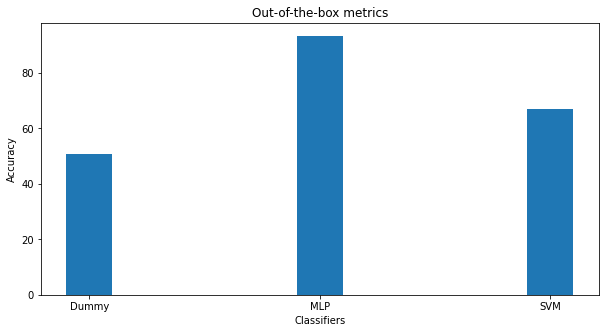

In [ ]:
import matplotlib.pyplot as plt

x = ['Dummy','MLP', 'SVM']
x_axis = np.arange(len(x))
plt.figure(figsize=(10, 5))

plt.bar(x_axis, out_of_the_box_results, 0.2)
plt.xticks(x_axis, x)
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Out-of-the-box metrics')
plt.show()

We can see that our out-of-the-box MLP classifier is by far the best classifier of the 3 with a very good accuracy score of 92.51%. It even needs much less time compared to the SVM model.

## Optimization

Due to the very large volume of data we have to make some decisions based on the dataset that will minimize the number of pipeline architectures that we have to test (Kaggle sessions expire after a certain amount as well).


In [ ]:
train_variance = X_train.var(axis=0)
print('The variance of our features is:', train_variance)

The variance of our features is: [2.28459929e+02 9.94293130e+05 1.76311414e+00 2.32583197e+00
 1.95698483e+00 1.63229974e+00 1.76764022e+00 1.82115689e+00
 1.73997514e+00 1.77684714e+00 1.65984098e+00 1.73079886e+00
 1.39451944e+00 1.60121119e+00 1.38217027e+00 1.72204345e+00
 1.46158769e+03 1.49310549e+03 2.49944366e-01 1.49306902e-01
 2.14041615e-01 2.47488630e-01 6.69223584e-02]


We have some very small variances so we will experiment with a selector to ignore those features.


In [ ]:
no_of_satisfied = np.sum(y_train, axis=0)
samples = y_train.shape[0]
print('The percentage of satisfied customers is: {:.2f} %'.format((no_of_satisfied / samples) * 100))
print('The percentage of dissatisfied customers is: {:.2f} %'.format((1 - (no_of_satisfied / samples)) * 100))

The percentage of satisfied customers is: 43.33 %
The percentage of dissatisfied customers is: 56.67 %


We can conclude that the data is quite balanced and do not require any special treatment or resampling.

We will also normalize our dataset using a Standard Scaler, which we know pairs well with MLPs and handles outliers decently too.

Finally, the number of samples we have is much greater than the number of features, so our 23 features shouldn't pose a problem. Nevertheless, we will experiment with using a VarianceThreshold selector as well as a PCA dimensionality reduction method.

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from tune_sklearn import TuneGridSearchCV
import logging

selector = VarianceThreshold()
scaler = StandardScaler()
pca = PCA()

# These are the pipeline architectures I want to test out and optimize
# Afterwards, I will find the best of all of the optimized ones
steps = [
    [],
    [('selector', selector)],
    [('scaler', scaler)],
    [('pca', pca)],
    [('selector', selector), ('scaler', scaler)],
    [('selector', selector), ('pca', pca)],
    [('scaler', scaler), ('pca', pca)],
    [('selector', selector), ('scaler', scaler), ('pca', pca)]
]

# Creating the grid of values that Ι will use to optimize the above architectures
vthreshold = [0, 0.1, 1]
n_components = [5, 10, 15]
tf = [True, False]

logger = logging.getLogger('ray.tune')
logger.setLevel('CRITICAL')

Because our sample volume is very large and SVM classifier needs quadratic time over the number of samples we decided to sample our dataset to greatly reduce the time needed to train our SVM model. We used only a fraction of ~5,000 samples to find out our best estimator for the problem. We will use the same samples to train our MLP model too, to earn a more fair comparison.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, train_size=0.05, random_state=0)
sss.get_n_splits(X_train, y_train)

X = X_train
y = y_train

for train_index, test_index in sss.split(X, y):
    X_new_train = X[train_index]
    y_new_train = y[train_index]
    print('My new array shapes are:')
    print(X_new_train.shape)
    print(y_new_train.shape)

My new array shapes are:
(5195, 23)
(5195,)


We confirm that we still have the same balance of classes in our new training dataset.

In [ ]:
no_of_satisfied = np.sum(y_new_train, axis=0)
samples = y_new_train.shape[0]
print('The percentage of satisfied customers is: {:.2f} %'.format((no_of_satisfied / samples) * 100))
print('The percentage of dissatisfied customers is: {:.2f} %'.format((1 - (no_of_satisfied / samples)) * 100))

The percentage of satisfied customers is: 43.33 %
The percentage of dissatisfied customers is: 56.67 %


### MLP

In [ ]:
mlp = MLPClassifier(max_iter=5000)
mlp_opt_score = 0

for i in range(len(steps)):
    # Construct the pipe with the specific architecture for this classifier
    mySteps = steps[i][:]
    mySteps.append(('mlp', mlp))
    pipe = Pipeline(steps=mySteps, memory='tmp')
    
    # Construct a temporary dictionary with only the values needed for this pipe
    myDictionary = {
        'mlp__activation': ['logistic', 'tanh', 'relu'],
        'mlp__alpha': [0.00001, 0.0001, 0.001],
        'mlp__learning_rate_init': [0.0001, 0.001, 0.01]
    }
    for element in mySteps:   
        name = element[0]
        if name == 'selector':
            myDictionary['selector__threshold'] = vthreshold
        elif name == 'pca':
            myDictionary['pca__n_components'] = n_components
        elif name == 'scaler':
            myDictionary['scaler__with_mean'] = tf
            myDictionary['scaler__with_std'] = tf
            
    estimator = TuneGridSearchCV(
        pipe, 
        myDictionary, 
        early_stopping=True,
        max_iters=20,
        scoring='accuracy', 
        cv=5 
    )
    
    # Find the optimal model for this pipeline architecture
    start_time = time.time()
    estimator.fit(X_new_train, y_new_train)
    end_time = time.time()
    
    duration = math.ceil(end_time - start_time)
    print('Pipeline architecture {} finished after {} min {} sec'.format(i+1, duration//60, duration%60))
    
    if estimator.best_score_ > mlp_opt_score:
        mlp_opt_estimator = estimator.best_estimator_
        mlp_opt_score = estimator.best_score_
        
print('Optimal MLP estimator is:\n{}'.format(mlp_opt_estimator))
print('with score: {:.2f} %'.format(mlp_opt_score * 100))

Pipeline architecture 1 finished after 0 min 24 sec
Pipeline architecture 2 finished after 0 min 45 sec
Pipeline architecture 3 finished after 0 min 47 sec
Pipeline architecture 4 finished after 0 min 47 sec
Pipeline architecture 5 finished after 1 min 42 sec
Pipeline architecture 6 finished after 1 min 36 sec
Pipeline architecture 7 finished after 2 min 3 sec
Pipeline architecture 8 finished after 4 min 58 sec
Optimal MLP estimator is:
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0)),
                ('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(alpha=1e-05, learning_rate_init=0.01,
                               max_iter=5000))])
with score: 93.09 %


### SVM

In [ ]:
svm = SVC()
svm_opt_score = 0

for i in range(len(steps)):
    # Construct the pipe with the specific architecture for this classifier
    mySteps = steps[i][:]
    mySteps.append(('svm', svm))
    pipe = Pipeline(steps=mySteps, memory='tmp')
    
    # Construct a temporary dictionary with only the values needed for this pipe
    myDictionary = {
        'svm__C': [0.1, 1, 10],
#         'svm__kernel': ['poly', 'rbf', 'sigmoid'],
        'svm__kernel': ['rbf', 'sigmoid'],
        'svm__gamma': ['scale', 'auto']
    }
    for element in mySteps:   
        name = element[0]
        if name == 'selector':
            myDictionary['selector__threshold'] = vthreshold
        elif name == 'pca':
            myDictionary['pca__n_components'] = n_components
        elif name == 'scaler':
            myDictionary['scaler__with_mean'] = tf
            myDictionary['scaler__with_std'] = tf
            
    estimator = TuneGridSearchCV(
        pipe, 
        myDictionary, 
        max_iters=20,
        scoring='accuracy',
        cv=5
    )
    
    # Find the optimal model for this pipeline architecture
    start_time = time.time()
    estimator.fit(X_new_train, y_new_train)
    end_time = time.time()
    
    duration = math.ceil(end_time - start_time)
    print('Pipeline architecture {} finished after {} min {} sec'.format(i+1, duration//60, duration%60))
    
    if estimator.best_score_ > svm_opt_score:
        svm_opt_estimator = estimator.best_estimator_
        svm_opt_score = estimator.best_score_
        
print('Optimal SVM estimator is:\n{}'.format(svm_opt_estimator))
print('with score: {:.2f} %'.format(svm_opt_score * 100))

Pipeline architecture 1 finished after 0 min 36 sec
Pipeline architecture 2 finished after 1 min 20 sec
Pipeline architecture 3 finished after 1 min 31 sec
Pipeline architecture 4 finished after 1 min 8 sec
Pipeline architecture 5 finished after 4 min 11 sec
Pipeline architecture 6 finished after 3 min 3 sec
Pipeline architecture 7 finished after 3 min 12 sec
Pipeline architecture 8 finished after 9 min 35 sec
Optimal SVM estimator is:
Pipeline(memory='tmp',
         steps=[('scaler', StandardScaler(with_mean=False)),
                ('svm', SVC(C=10))])
with score: 93.30 %


Finally, we try our final 2 best estimators (one for each classifier type) at our test set (after training on the entire training dataset), measure the time needed to fit and predict, and see how they do.

In [ ]:
# Optimal MLP estimator
fit_start = time.time()
mlp_opt_estimator.fit(X_train, y_train)
fit_end = time.time()

predict_start = time.time()
mlp_preds = mlp_opt_estimator.predict(X_test)
predict_end = time.time()

mlp_fit_time = math.ceil(fit_end - fit_start)
mlp_predict_time = math.ceil(predict_end - predict_start)
mlp_score = accuracy_score(y_test, mlp_preds) * 100

print('Optimal MLP estimator')
print('Fit time: {} min {} sec'.format(mlp_fit_time // 60, mlp_fit_time % 60))
print('Predict time: {} min {} sec'.format(mlp_predict_time // 60, mlp_predict_time % 60))
print('Total time: {} min {} sec'.format((mlp_fit_time + mlp_predict_time) // 60, (mlp_fit_time + mlp_predict_time) % 60))
print('Accuracy: {:.2f} %\n'.format(mlp_score))

Optimal MLP estimator
Fit time: 1 min 6 sec
Predict time: 0 min 1 sec
Total time: 1 min 7 sec
Accuracy: 95.93 %



In [ ]:
# Optimal SVM estimator
fit_start = time.time()
svm_opt_estimator.fit(X_train, y_train)
fit_end = time.time()

predict_start = time.time()
svm_preds = svm_opt_estimator.predict(X_test)
predict_end = time.time()

svm_fit_time = math.ceil(fit_end - fit_start)
svm_predict_time = math.ceil(predict_end - predict_start)
svm_score = accuracy_score(y_test, svm_preds) * 100

print('Optimal SVM estimator')
print('Fit time: {} min {} sec'.format(svm_fit_time // 60, svm_fit_time % 60))
print('Predict time: {} min {} sec'.format(svm_predict_time // 60, svm_predict_time % 60))
print('Total time: {} min {} sec'.format((svm_fit_time + svm_predict_time) // 60, (svm_fit_time + svm_predict_time) % 60))
print('Accuracy: {:.2f} %'.format(svm_score))

Optimal SVM estimator
Fit time: 5 min 18 sec
Predict time: 0 min 19 sec
Total time: 5 min 37 sec
Accuracy: 95.76 %


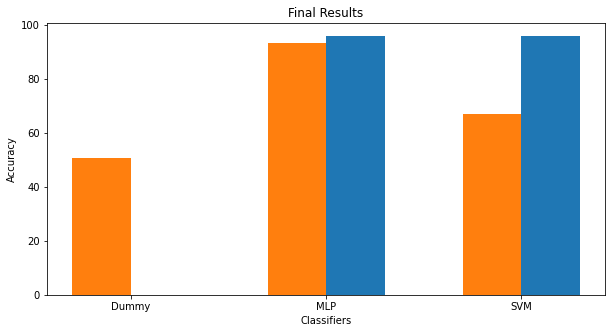

In [ ]:
x = ['Dummy', 'MLP', 'SVM']
x_axis = np.arange(len(x))
plt.figure(figsize=(10, 5))
# plt.figure()

plt.bar(x_axis+0.15, [0, mlp_score, svm_score], 0.3, label='Optimized')
plt.bar(x_axis-0.15, out_of_the_box_results, 0.3, label='Out-of-the-box')
plt.xticks(x_axis, x)
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Final Results')
plt.show()

We can see that both our optimized MLP and SVM models have about the same accuracy score ~96%. The total time that the optimized MLP model needed was 1 min and 7 sec vs 5 min and 37 sec of the optimized SVM model. Also, the out-of-the-box MLP model gave an accuracy of 93.36%, which is also very good and only took 41 seconds.

However, all the above times are very small and would not make a difference for us. Therefore, we can choose whichever of the 2 optimized classifiers we prefer. Let's say:

Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0)),
                ('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(alpha=1e-05, learning_rate_init=0.01,
                               max_iter=5000))])

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Heatmap Visualization Parameters
def visualize_confusion_matrix(conf):
    group_names = ['Correctly satisfied', 'Predicted satisfied while not', 'Predicted dissatisfied while not', 'Correctly dissatisfied']
    group_counts = [value for value in conf.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in conf.flatten() / np.sum(conf)]

    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(conf, annot=labels, fmt='', cmap='Blues')

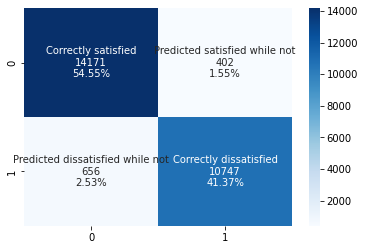

In [ ]:
mlp_opt_conf = confusion_matrix(y_test, mlp_preds)
visualize_confusion_matrix(mlp_opt_conf)

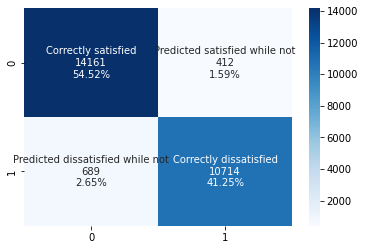

In [ ]:
svm_opt_conf = confusion_matrix(y_test, svm_preds)
visualize_confusion_matrix(svm_opt_conf)

The above confusion matrices allow us to see that the difference in accurate predictions is pretty small either of the optimized classifiers we choose. The optimized MLP classifier predicts 10 more false positives, while the optimized SVM classifier 33 more false negatives. The difference in accuracy percentage however is extremely small.